In [127]:
# prompt: list all files in the following folder  /Users/hemantmangla/Documents/workspace/nandi/scripts/chennai-metro/open-trip-planner/chennai.metro.gtfs, also read the data from those files and put in dataframes

import pandas as pd
import os
from enum import Enum


class Transport(Enum):
    SUBURBAN = 1
    METRO = 2
    BUS = 3


transport_type = Transport.BUS

if transport_type == Transport.SUBURBAN:
  folder_name, subfolder_name = "chennai-subway", "chennai.suburban"
elif transport_type == Transport.METRO:
  folder_name, subfolder_name = "chennai-metro", "chennai.metro"
elif transport_type == Transport.BUS:
  folder_name, subfolder_name = "chennai-bus", "chennai.bus"
else:
  raise ValueError("Invalid transport type")

# Replace with the actual path to your folder
folder_path = f"/Users/hemantmangla/Documents/workspace/nandi/scripts/{folder_name}/open-trip-planner/{subfolder_name}.gtfs"

# Check if the folder exists
if not os.path.exists(folder_path):
  print(f"Error: Folder '{folder_path}' not found.")
else:
  dataframes = {}
  for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):  # Assuming GTFS files are text files
      filepath = os.path.join(folder_path, filename)
      try:
        # Attempt to read the file as a CSV (GTFS files are typically CSV-like)
        df = pd.read_csv(filepath)
        dataframes[filename] = df
        print(f"Successfully read '{filename}' into a DataFrame.")
      except pd.errors.ParserError:
        print(f"Warning: Could not parse '{filename}' as a CSV. Skipping.")
      except Exception as e:
        print(f"An error occurred while processing '{filename}': {e}")

  # Now you have a dictionary 'dataframes' where keys are filenames and values are the DataFrames
  # Access them like this:
  # if "agency.txt" in dataframes:
  #     print(dataframes["agency.txt"].head())


Successfully read 'agency.txt' into a DataFrame.
Successfully read 'stop_times.txt' into a DataFrame.
Successfully read 'frequencies.txt' into a DataFrame.
Successfully read 'trips.txt' into a DataFrame.
Successfully read 'stops.txt' into a DataFrame.
Successfully read 'calendar.txt' into a DataFrame.
Successfully read 'routes.txt' into a DataFrame.


In [128]:
routes = dataframes['routes.txt']

stop_times = dataframes['stop_times.txt']

trips = dataframes['trips.txt']

routes

,route_id,route_short_name,route_long_name,agency_id,route_type
0,tmhpmjEo,109CT,ADYAR OLD DEPOT - KOVALAM BUS STAND,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
1,TRiLnvcP,19T,KOVALAM BUS STAND - THYAGARAYA NAGAR BUS DEPOT,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
2,QVgNwcGb,19T,THYAGARAYA NAGAR BUS DEPOT - KOVALAM BUS STAND,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
3,aqhekrvb,5B,THYAGARAYA NAGAR BUS DEPOT - MYLAPORE TANK,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
4,hzUvMKyT,5B,MYLAPORE TANK - THYAGARAYA NAGAR BUS DEPOT,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
...,...,...,...,...,...
300,ljduaIRb,70H,HASTHINAPURAM - M.G.R.KOYAMBEDU,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
301,bkIVSyXX,70H,M.G.R.KOYAMBEDU - HASTHINAPURAM,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
302,IBzAkXzb,91A,THIRUVANMIYUR DEPOT - HASTHINAPURAM,4b17bd06-ae7e-48e9-85bf-282fb310209c,3
303,rjrWmjOa,91A,HASTHINAPURAM - THIRUVANMIYUR DEPOT,4b17bd06-ae7e-48e9-85bf-282fb310209c,3


In [137]:
# prompt: routes has route_id which is inside trips, figure out how many trips each route is having. Along with trips has trip_id which is inside stop_times, figure out how many stops a trip having

import pandas as pd
import numpy as np
# Merge routes and trips dataframes
merged_routes_trips = pd.merge(routes, trips, on='route_id', how='left')

# Group by route_id and count the number of trips for each route
route_trip_counts = merged_routes_trips.groupby('route_id')['trip_id'].count().reset_index()
route_trip_counts['route_long_name'] = np.array(x.replace('Puratchi Thalaivar Dr.M.G.Ramachandran Central', 'MGR').replace('Puratchi Thalaivi Dr.J.Jayalalithaa', '') for x in merged_routes_trips.groupby('route_id')['route_long_name'].first().values)
route_trip_counts.rename(columns={'trip_id': 'trip_count'}, inplace=True)

route_trip_counts.sort_values(by='route_long_name', ascending=False, inplace=True)

# Display the results
print(route_trip_counts)
# # Merge trips and stop_times dataframes
merged_trips_stop_times = pd.merge(trips, stop_times, on='trip_id', how='left')
# # # # Group by trip_id and count the number of stops for each trip
trip_stop_arrays = (
    merged_trips_stop_times
    .sort_values(['trip_id', 'stop_sequence'])  # Ensure ordering
    .groupby('trip_id')['stop_id']
    .agg(list)
    .reset_index()
)
trip_stop_arrays.rename(columns={'stop_id': 'stops'}, inplace=True)

trip_stop_counts = merged_trips_stop_times.groupby('trip_id')['stop_id'].count().reset_index()
trip_stop_counts.rename(columns={'stop_id': 'stop_count'}, inplace=True)

# To figure out trips with same stops count
# print(trip_stop_counts.groupby('stop_count')['trip_id'].count().reset_index())
trip_stop_arrays['stops_string'] = trip_stop_arrays['stops'].apply(lambda stops: '->'.join(map(str, stops)))
print(trip_stop_arrays.groupby('stops_string')['trip_id'].count().reset_index().to_string())
# # Merge the results to have route_id, trip_count, trip_id, and stop_count
final_df = pd.merge(merged_routes_trips, merged_trips_stop_times, on='trip_id', how='left')
final_df = pd.merge(final_df, trip_stop_counts, on='trip_id', how='left')
final_df
# # Display the final dataframe
print(final_df[['route_short_name', 'trip_id', 'stop_count']].head())


     route_id  trip_count                                    route_long_name
75   MUCyRVIN           1  WALAJABAD BUS STAND - TAMBARAM SANATORIUM BUS ...
158  ZnITscBZ           1           VIVEKANANDA HOUSE TERMINUS - T.V.K.NAGAR
279  umBMjDKT           1          VIVEKANANDA HOUSE - ANNA NAGAR WEST DEPOT
242  pqBlWxRj           1   VENGAMBAKKAM BUS STAND - TAMBARAM WEST BUS STAND
182  dNRXMCEx           1                VELACHERY - TAMBARAM WEST BUS STAND
..        ...         ...                                                ...
67   KjfKOxNm           1             ALANDUR METRO R.S - GURU NANAK COLLEGE
108  SgRxcWWa           1                                ALAMATHI - BROADWAY
229  oXSnLzxt           1               AGARAMTHEN - TAMBARAM WEST BUS STAND
69   LGxAcQwG           1  AG DMS METRO STATION - NUNGAMBAKKAM RAILWAY ST...
271  tmhpmjEo           1                ADYAR OLD DEPOT - KOVALAM BUS STAND

[305 rows x 3 columns]
                                                    

In [126]:
', '.join(dataframes['stops.txt'].stop_code.to_list())

'SCC, SEG, SNP, SKM, SPC, SSN, SAE, SAT, STI, SKO, SCM, SAR, SVA, SAN, SSI, SAL, SMM, SWA, SMA, SHC, SGE, SLI, STL, SGM, STE, SCR, SSA, SLM, SGU, SOT, SME, SAP, SWD, SWN, STV, STT, SKP, STG, SNW, STR, STC'

In [140]:
# prompt: read json file and import in "Data" field of it in dataframe `~/Downloads/AMNEX_ROUTE_STATION_DETAILS.json`

import pandas as pd
import json

# Load the JSON data from the file
with open("/Users/hemantmangla/Downloads/AMNEX_ROUTE_STATION_DETAILS.json", "r") as f:
    json_data = json.load(f)

# Assuming 'Data' is a key in the JSON object
data_list = json_data.get("Data", [])

# Check if the "Data" field exists and is a list
if not isinstance(data_list, list):
  print("Error: 'Data' field is not a list in the JSON file.")
else:
  # Create a Pandas DataFrame
  amnex_data = pd.DataFrame(data_list)
amnex_data

,routeid,routeno,routename,srno,routesrno,connectorsrno,geofencemstid,totaldistance,totaltime,pregeofencedistance,pregeofencetime,latitude,longitude,placename
0,7458,17D,Broadway - KK Nagar,1,1,0,3,0.00,2025-02-06T00:00:00,0.00,2025-02-06T00:00:00,13.08750,80.28380,BROADWAY(EXIT)
1,7458,17D,Broadway - KK Nagar,2,2,0,52,0.38,2025-02-06T00:02:00,0.38,2025-02-06T00:02:00,13.08751,80.28142,FLOWER BAZZAR(MGR CENTRAL STATION)
2,7458,17D,Broadway - KK Nagar,3,3,0,102,1.70,2025-02-06T00:07:00,1.32,2025-02-06T00:05:00,13.08135,80.27319,PARK STATION(HOTEL EVEREST)
3,7458,17D,Broadway - KK Nagar,4,4,0,55,2.31,2025-02-06T00:09:00,0.61,2025-02-06T00:02:00,13.08062,80.26771,HOTEL EVEREST(EGMORE RAILWAY STATION)
4,7458,17D,Broadway - KK Nagar,5,5,0,45,3.30,2025-02-06T00:13:00,0.99,2025-02-06T00:04:00,13.07736,80.26128,EGMORE RAILWAY STATION(T N SPORTS AUTHORITY)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96081,10018,11 CUT5,THIYAGARAYANAGAR TERMINUS TO L.F.C,2,2,0,9443,5.58,2025-03-06T00:23:00,5.58,2025-03-06T00:23:00,13.05162,80.25035,GEMINI P H(DMS)
96082,10019,11 CUT6,L.F.C TO THIYAGARAYANAGAR TERMINUS,1,1,0,9443,0.00,2025-03-06T00:00:00,0.00,2025-03-06T00:00:00,13.05162,80.25035,GEMINI P H(DMS)
96083,10019,11 CUT6,L.F.C TO THIYAGARAYANAGAR TERMINUS,2,2,0,5823,3.49,2025-03-06T00:11:00,3.49,2025-03-06T00:11:00,13.03452,80.23025,THIYAGARAYANAGAR TERMINUS(Exit)
96084,10029,70LCT,AMBATTUR INDUSTRIAL ESTATE TO AMBATTUR INDUSTR...,1,1,0,9920,0.00,2025-03-06T00:00:00,0.00,2025-03-06T00:00:00,13.09948,80.17001,AMBATTUR INDUSTRIAL ESTATE(AMBATTUR INDUSTRIAL...


In [166]:
# prompt: Do basic analysis of amnex_data bus data

import pandas as pd
import os
from enum import Enum
import numpy as np
import json

# ... (Your existing code) ...

# Analysis of amnex_data
print("\nAMNEX Data Analysis:")
print("Number of records:", len(amnex_data))
print("Columns:", amnex_data.columns.tolist())

# Unique values in key columns (replace with actual relevant columns)
key_cols = ['routeid', 'routeno', 'routename', 'routesrno', 'connectorsrno', 'placename', 'geofencemstid']  # Replace with actual column names
for col in key_cols:
    if col in amnex_data.columns:
      print(f"\nUnique values for '{col}':")
      print(amnex_data[col].unique()[:20])  # Limiting to first 20 for brevity
      print(f"Number of Unique values for {col}:", len(amnex_data[col].unique()))


# Check for missing values
print("\nMissing values per column:")
print(amnex_data.isnull().sum())


# Example: Find routes with the most stations
route_station_counts = amnex_data.groupby('routeid')['placename'].count().reset_index()
route_station_counts.rename(columns={'placename': 'Station_Count'}, inplace=True)
route_station_counts = route_station_counts.sort_values('Station_Count', ascending=False)
print("\nRoutes with the most stations:")
print(route_station_counts[route_station_counts['Station_Count'] < 5]) #Top 10


#Further analysis can be done here depending on the objective
#Example: compare the amnex data with GTFS data

# Merge amnex data with GTFS data
# This is highly dependent on the structure of both dataset, this is a suggestion and needs to be adjusted.
#You need to find a common key between two datasets
#merged_df = pd.merge(final_df, amnex_data, left_on='route_short_name', right_on='Route_ID', how='left')
#print(merged_df)



AMNEX Data Analysis:
Number of records: 96086
Columns: ['routeid', 'routeno', 'routename', 'srno', 'routesrno', 'connectorsrno', 'geofencemstid', 'totaldistance', 'totaltime', 'pregeofencedistance', 'pregeofencetime', 'latitude', 'longitude', 'placename']

Unique values for 'routeid':
[7458  255 6770 6804  256  257  240  202 1481  203  188  189  190  191
  198  196  194  204  215  216]
Number of Unique values for routeid: 5959

Unique values for 'routeno':
['17D' '21-Up-R' '21' '18K' '17D-U-D' '17D Dead' '17D-Up-D' '17D Dead1'
 'S787' '18K CT' '21 Dead' '21 Dead1' '21 Cut 3' '17DCT3' '17D EXT'
 '17DCT1' '17DCT2' '21X' '21 CT' '2A']
Number of Unique values for routeno: 2490

Unique values for 'routename':
['Broadway  - KK Nagar' 'KK Nagar - Broadway' 'Broadway - Mandaveli'
 'Mandaveli - Broadway' 'Broadway - Saidapet West'
 'Saidapet West - Broadway' 'Central Depot - Broadway'
 'Broadway - Central Depot' 'KK Nagar Depot - KK Nagar B.S.'
 'KK Nagar B.S. - KK Nagar Depot' 'K.K.NAGAR-M.G.

In [163]:
# prompt: analyse the relation b/w routeid, routeno and routename. Why count is different?

# Analysis of the relationship between routeid, routeno, and routename in amnex_data
# and why the counts might differ.

# Assuming 'amnex_data' DataFrame is already loaded as shown in the provided code.

print("\nAnalysis of routeid, routeno, and routename:")

# Count unique values for each column
print(f"Unique routeid count: {amnex_data['routeid'].nunique()}")
print(f"Unique routeno count: {amnex_data['routeno'].nunique()}")
print(f"Unique routename count: {amnex_data['routename'].nunique()}")

# Check for potential reasons for differing counts:

# 1. One-to-many relationships:
# A single 'routeid' might correspond to multiple 'routeno' or 'routename' values.  This could be due to variations in route numbers or names for different segments or directions of the same route.

# Example:  Group by 'routeno' and observe the unique 'routeid'
route_variations = amnex_data.groupby('routeno').agg({'routeid': 'nunique', 'routename': 'nunique'}).reset_index()
print("\nVariations in routeno and routename per routeid:")
print(route_variations[route_variations['routeid'] > 1].sort_values(by='routeid'))


# Example:  Group by 'routename' and observe the unique 'routeno'
route_variations = amnex_data.groupby('routename').agg({'routeno': 'nunique'}).reset_index()
print("\nTotal routeno in a routename:")
print(route_variations[route_variations['routeno'] > 1].sort_values(by='routeno'))


# Example:  Group by 'routename' and observe the unique 'routeno'
route_variations = amnex_data.groupby('routeno').agg({'routename': 'nunique'}).reset_index()
print("\nTotal routename in a routeno:")
print(route_variations[route_variations['routename'] > 1].sort_values(by='routename'))


# 2. Missing or inconsistent data:
# There might be missing values in one or more of the columns, or inconsistencies in how the data is entered.

# Check for missing values:
# print("\nMissing values in relevant columns:")
# print(amnex_data[['routeid', 'routeno', 'routename']].isnull().sum())

# # Inspect rows with missing values
# print("\nExamples of rows with missing values:")
# print(amnex_data[amnex_data['routeid'].isnull()]) # Replace 'routeid' with the column name you want to check
# print(amnex_data[amnex_data['routeno'].isnull()]) # Replace 'routeno' with the column name you want to check
# print(amnex_data[amnex_data['routename'].isnull()]) # Replace 'routename' with the column name you want to check


# 3. Data duplication:
# The dataset might contain duplicate rows, inflating the counts of some values.

# Check for duplicates
print("\nNumber of duplicate rows in amnex data:", amnex_data.duplicated().sum())

# Further investigation:

# Explore the relationship between the columns visually:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.scatter(amnex_data['routeid'], amnex_data['routeno'], s=10)
# plt.xlabel('routeid')
# plt.ylabel('routeno')
# plt.title('routeid vs. routeno')
# plt.show()

# ... (Similar plots for other column pairs)


# Examine specific routeid values with multiple routeno/routename values
# ... (Further code based on the identified cases)


# Note: The specific analysis will depend on the context and the intended use of the data.



Analysis of routeid, routeno, and routename:
Unique routeid count: 5959
Unique routeno count: 2490
Unique routename count: 3982

Variations in routeno and routename per routeid:
        routeno  routeid  routename
1320    53S CT1        2          2
1456    56D CT2        2          2
1457    56D CT3        2          2
1460  56DET CT1        2          2
1466    56J CT1        2          2
...         ...      ...        ...
495        166K        6          6
496        166X        6          6
0             1        6          6
351         12X        7          7
1647        597        8          8

[1526 rows x 3 columns]

Total routeno in a routename:
                                              routename  routeno
3916                   VYASARPADI (DEPOT) TO MOOLAKADAI        2
2864                         SECRETARIAT to ANNA SQUARE        2
1405               KILAMBAKKAM BUS TERMINUS TO BROADWAY        2
2865                            SECRETARIAT to BROADWAY        2
1402  KI

In [176]:
station_counts = route_station_counts.groupby('Station_Count').nunique('route_id').reset_index()
station_counts

,Station_Count,routeid
0,2,2449
1,3,41
2,4,62
3,5,39
4,6,50
...,...,...
62,64,3
63,65,10
64,66,3
65,67,4


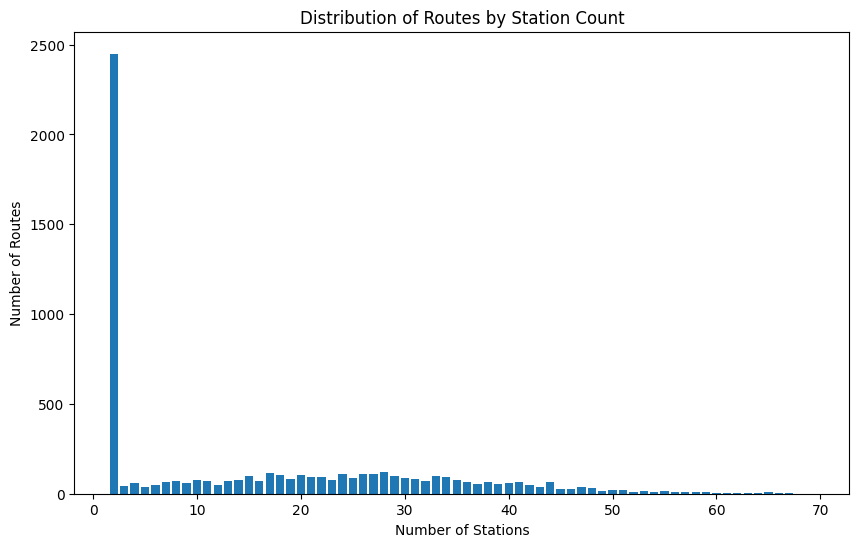

In [179]:
# prompt: plot station_counts = route_station_counts.groupby('Station_Count').nunique('route_id').reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(station_counts['Station_Count'], station_counts['routeid'])
plt.xlabel('Number of Stations')
plt.ylabel('Number of Routes')
plt.title('Distribution of Routes by Station Count')
plt.show()



Analysis of 'totaldistance':
count    96086.000000
mean        13.190012
std         11.745143
min          0.000000
25%          3.920000
50%         10.200000
75%         19.420000
max         86.180000
Name: totaldistance, dtype: float64


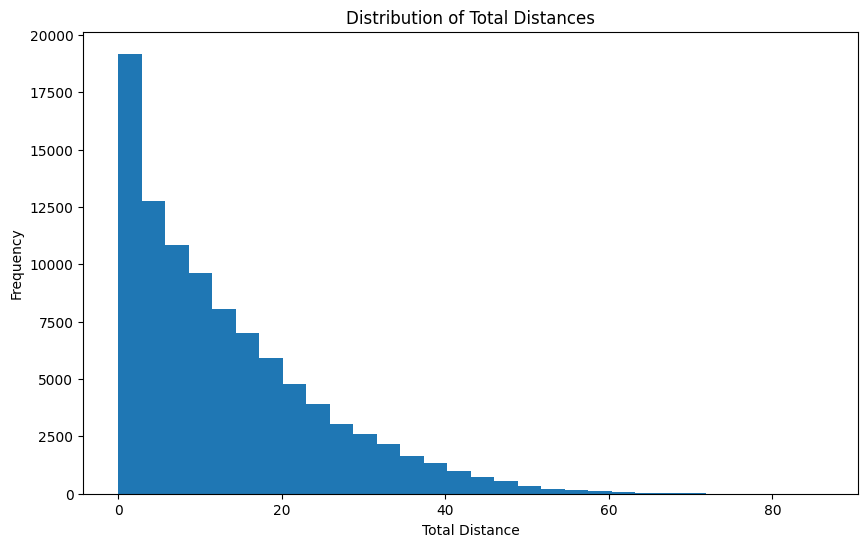

In [183]:
# prompt: Analyse totaldistance in amnex_data, try to find anomalies if any

import matplotlib.pyplot as plt
# Assuming 'amnex_data' DataFrame is already loaded as shown in the provided code.

# Analyze 'totaldistance' column (if it exists)
if 'totaldistance' in amnex_data.columns:
    print("\nAnalysis of 'totaldistance':")

    # Summary statistics
    print(amnex_data['totaldistance'].describe())

    # Check for negative or zero distances (potential anomalies)
    negative_distances = amnex_data[amnex_data['totaldistance'] < 0]
    if not negative_distances.empty:
        print("\nRoutes with non-positive total distances:")
        print(negative_distances)

    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(amnex_data['totaldistance'], bins=30)
    plt.xlabel('Total Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Total Distances')
    plt.show()

else:
    print("'totaldistance' column not found in amnex_data.")
